# Twin-Delayed DDPG

## Installing the packages

In [ ]:
!pip install pybullet
!pip install gym==0.22.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 91.7 MB 99 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 631 kB 4.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.22.0-py3-none-any.whl size=708396 sha256=7ec01e34f9cdf80ccfa3fc7857fdc1490f48b387893a0153f56371bb70b11183
  Stored in directory: /root/.cache/pip/wheels/4d/6e/7d/0e050cb65b427dd0db5c5ab2c9a1f1ffa3d58db2f4db516268
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


## Importing the libraries

In [ ]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import pybullet_envs
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from gym import wrappers
from torch.autograd import Variable
from collections import deque

## Step 1: We initialize the Experience Replay memory

In [ ]:
class ReplayBuffer(object):

  # max_size : capacity of the memory(transition)
  def __init__(self, max_size=1e6):
    self.storage = [] # list of transition
    self.max_size = max_size
    self.ptr = 0 # pointer

  def add(self, transition):
    if len(self.storage) == self.max_size:
      # rebuild memory
      self.storage[int(self.ptr)] = transition
      self.ptr = (self.ptr + 1) % self.max_size
    else:
      self.storage.append(transition)

  # put trainsition into batch
  def sample(self, batch_size):
    ind = np.random.randint(0, len(self.storage), size=batch_size)
    batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = [], [], [], [], []
    for i in ind: 
      state, next_state, action, reward, done = self.storage[i]
      batch_states.append(np.array(state, copy=False))
      batch_next_states.append(np.array(next_state, copy=False))
      batch_actions.append(np.array(action, copy=False))
      batch_rewards.append(np.array(reward, copy=False))
      batch_dones.append(np.array(done, copy=False))
    return np.array(batch_states), np.array(batch_next_states), np.array(batch_actions), np.array(batch_rewards).reshape(-1, 1), np.array(batch_dones).reshape(-1, 1)

## Step 2: We build one neural network for the Actor model and one neural network for the Actor target

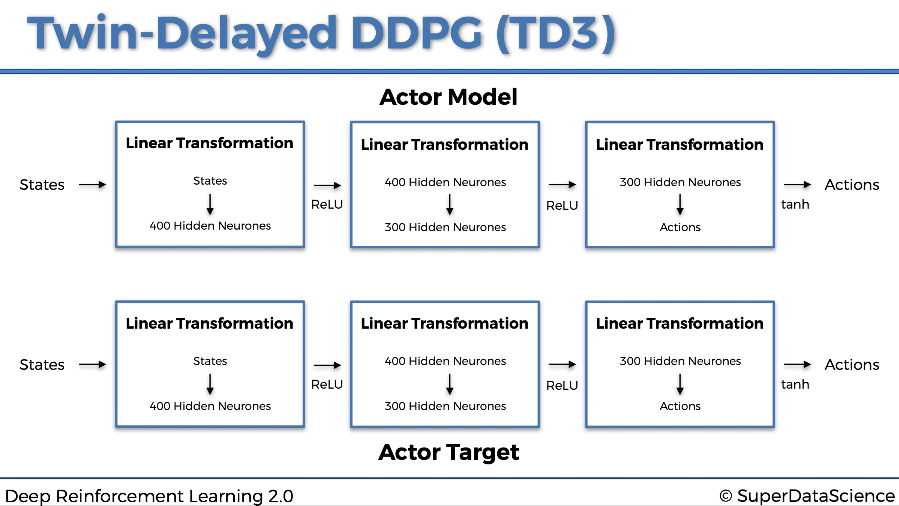

In [ ]:
# state_dim -> 400 -> 300 -> action_dim
class Actor(nn.Module):
  
  # state_dim : number of components in the input state vector
  # action_dim : number of actions(outputs) played at the same time(T)
  # max_action : range of remembering to clip actions
  def __init__(self, state_dim, action_dim, max_action):
    super(Actor, self).__init__()
    self.layer_1 = nn.Linear(state_dim, 400)
    self.layer_2 = nn.Linear(400, 300)
    self.layer_3 = nn.Linear(300, action_dim)
    self.max_action = max_action

  def forward(self, x):
    x = F.relu(self.layer_1(x))
    x = F.relu(self.layer_2(x))
    # why multiply self.max_action? : 
    # because -1 <torch.tanh < 1, makes action to go back to the original range of action values
    x = self.max_action * torch.tanh(self.layer_3(x))
    return x

## Step 3: We build two neural networks for the two Critic models and two neural networks for the two Critic targets

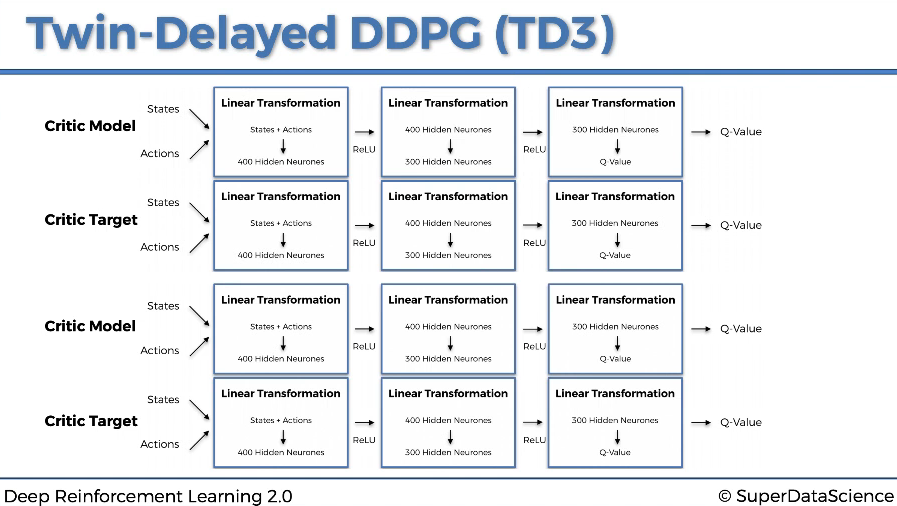

In [ ]:
class Critic(nn.Module):
  
  def __init__(self, state_dim, action_dim):
    super(Critic, self).__init__()
    # Defining the first Critic neural network
    self.layer_1 = nn.Linear(state_dim + action_dim, 400)
    self.layer_2 = nn.Linear(400, 300)
    self.layer_3 = nn.Linear(300, 1)
    # Defining the second Critic neural network
    self.layer_4 = nn.Linear(state_dim + action_dim, 400)
    self.layer_5 = nn.Linear(400, 300)
    self.layer_6 = nn.Linear(300, 1)

  def forward(self, x, u):
    xu = torch.cat([x, u], 1)
    # Forward-Propagation on the first Critic Neural Network
    x1 = F.relu(self.layer_1(xu)) # concatenation of the state(x) and action(u)
    x1 = F.relu(self.layer_2(x1))
    x1 = self.layer_3(x1)
    # Forward-Propagation on the second Critic Neural Network
    x2 = F.relu(self.layer_4(xu))
    x2 = F.relu(self.layer_5(x2))
    x2 = self.layer_6(x2)
    return x1, x2

  # return Q value output by the first critic
  def Q1(self, x, u):
    xu = torch.cat([x, u], 1)
    x1 = F.relu(self.layer_1(xu))
    x1 = F.relu(self.layer_2(x1))
    x1 = self.layer_3(x1)
    return x1

## Steps 4 to 15: Training Process

In [ ]:
# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building the whole Training Process into a class

class TD3(object):
  
  def __init__(self, state_dim, action_dim, max_action):
    # build actor model
    self.actor = Actor(state_dim, action_dim, max_action).to(device)
    self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
    self.actor_target.load_state_dict(self.actor.state_dict()) # get state from actor model
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters())
    # build critic model
    self.critic = Critic(state_dim, action_dim).to(device)
    self.critic_target = Critic(state_dim, action_dim).to(device)
    self.critic_target.load_state_dict(self.critic.state_dict()) # get state from actor critic
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters())
    self.max_action = max_action

  # why return type is converted tensor to numpy? : to clip the action after adding noise
  def select_action(self, state):
    state = torch.Tensor(state.reshape(1, -1)).to(device)
    return self.actor(state).cpu().data.numpy().flatten()

  def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
    
    for it in range(iterations):
      
      # Step 4: We sample a batch of transitions (s, s’, a, r) from the memory
      batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
      state = torch.Tensor(batch_states).to(device)
      next_state = torch.Tensor(batch_next_states).to(device)
      action = torch.Tensor(batch_actions).to(device)
      reward = torch.Tensor(batch_rewards).to(device)
      done = torch.Tensor(batch_dones).to(device)
      
      # Step 5: From the next state s’, the Actor target plays the next action a’
      next_action = self.actor_target(next_state) # when only call the object by itself, the first method is used. = self.actor_target.forward(next_state)   
      
      # Step 6: We add Gaussian noise to this next action a’ and we clamp it in a range of values supported by the environment
      noise = torch.Tensor(batch_actions).data.normal_(0, policy_noise).to(device) # normal_ : value from gaussian distribution of (mean, standard deviation)
      noise = noise.clamp(-noise_clip, noise_clip)
      next_action = (next_action + noise).clamp(-self.max_action, self.max_action)
      
      # Step 7: The two Critic targets take each the couple (s’, a’) as input and return two Q-values Qt1(s’,a’) and Qt2(s’,a’) as outputs
      target_Q1, target_Q2 = self.critic_target(next_state, next_action)
      
      # Step 8: We keep the minimum of these two Q-values: min(Qt1, Qt2)
      target_Q = torch.min(target_Q1, target_Q2)
      
      # Step 9: We get the final target of the two Critic models, which is: Qt = r + γ * min(Qt1, Qt2), where γ is the discount factor
      target_Q = reward + ((1 - done) * discount * target_Q).detach() # detach : when you do back-propagate, detached function is not computed = can do efficient computation
      
      # Step 10: The two Critic models take each the couple (s, a) as input and return two Q-values Q1(s,a) and Q2(s,a) as outputs
      current_Q1, current_Q2 = self.critic(state, action)
      
      # Step 11: We compute the loss coming from the two Critic models: Critic Loss = MSE_Loss(Q1(s,a), Qt) + MSE_Loss(Q2(s,a), Qt)
      critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
      
      # Step 12: We backpropagate this Critic loss and update the parameters of the two Critic models with a SGD optimizer
      self.critic_optimizer.zero_grad() # all the gradients is initialized to zeros
      critic_loss.backward()
      self.critic_optimizer.step()
      
      # Step 13: Once every two iterations, we update our Actor model by performing gradient ascent on the output of the first Critic model
      if it % policy_freq == 0:
        actor_loss = -self.critic.Q1(state, self.actor(state)).mean() # DPG : deterministic policy gradient(positive gradient technique)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Step 14: Still once every two iterations, we update the weights of the Actor target by polyak averaging
        # polyak averaging : that very small part is removed is replaced by very small part of the actor model weight
        # why double iteration? : get first the weight of the actor target that we want to update,
                                # second, the weight of the actor model in order to add component in the update
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        
        # Step 15: Still once every two iterations, we update the weights of the Critic target by polyak averaging
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
  
  # Making a save method to save a trained model
  def save(self, filename, directory):
    torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
  
  # Making a load method to load a pre-trained model
  def load(self, filename, directory):
    self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
    self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

## We make a function that evaluates the policy by calculating its average reward over 10 episodes

In [ ]:
def evaluate_policy(policy, eval_episodes=10):
  avg_reward = 0.
  for _ in range(eval_episodes):
    obs = env.reset()
    done = False
    while not done:
      action = policy.select_action(np.array(obs))
      obs, reward, done, _ = env.step(action)
      avg_reward += reward
  avg_reward /= eval_episodes
  print ("---------------------------------------")
  print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
  print ("---------------------------------------")
  return avg_reward

## We set the parameters

In [ ]:
env_name = "HalfCheetahBulletEnv-v0" # Name of a environment (set it to any Continous environment you want)
seed = 0 # Random seed number
start_timesteps = 1e4 # Number of iterations/timesteps before which the model randomly chooses an action, and after which it starts to use the policy network
eval_freq = 5e3 # How often the evaluation step is performed (after how many timesteps)
max_timesteps = 5e5 # Total number of iterations/timesteps
save_models = True # Boolean checker whether or not to save the pre-trained model
expl_noise = 0.1 # Exploration noise - STD value of exploration Gaussian noise
batch_size = 100 # Size of the batch
discount = 0.99 # Discount factor gamma, used in the calculation of the total discounted reward
tau = 0.005 # Target network update rate
policy_noise = 0.2 # STD of Gaussian noise added to the actions for the exploration purposes
noise_clip = 0.5 # Maximum value of the Gaussian noise added to the actions (policy)
policy_freq = 2 # Number of iterations to wait before the policy network (Actor model) is updated

## We create a file name for the two saved models: the Actor and Critic models

In [ ]:
file_name = "%s_%s_%s" % ("TD3", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")

---------------------------------------
Settings: TD3_HalfCheetahBulletEnv-v0_0
---------------------------------------


## We create a folder inside which will be saved the trained models

In [ ]:
if not os.path.exists("./results"):
  os.makedirs("./results")
if save_models and not os.path.exists("./pytorch_models"):
  os.makedirs("./pytorch_models")

## We create the PyBullet environment

In [ ]:
env = gym.make(env_name)

## We set seeds and we get the necessary information on the states and actions in the chosen environment

In [ ]:
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

## We create the policy network (the Actor model)

In [ ]:
policy = TD3(state_dim, action_dim, max_action)

## We create the Experience Replay memory

In [ ]:
replay_buffer = ReplayBuffer()

## We define a list where all the evaluation results over 10 episodes are stored

In [ ]:
evaluations = [evaluate_policy(policy)]

---------------------------------------
Average Reward over the Evaluation Step: -1433.638437
---------------------------------------


## We create a new folder directory in which the final results (videos of the agent) will be populated

In [ ]:
def mkdir(base, name):
    path = os.path.join(base, name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path
work_dir = mkdir('exp', 'brs')
monitor_dir = mkdir(work_dir, 'monitor')
max_episode_steps = env._max_episode_steps
save_env_vid = False
if save_env_vid:
  env = wrappers.Monitor(env, monitor_dir, force = True)
  env.reset()

## We initialize the variables

In [ ]:
total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
done = True
t0 = time.time()

## Training

In [ ]:
# We start the main loop over 500,000 timesteps
while total_timesteps < max_timesteps:
  
  # If the episode is done
  if done:

    # If we are not at the very beginning, we start the training process of the model
    if total_timesteps != 0:
      print("Total Timesteps: {} Episode Num: {} Reward: {}".format(total_timesteps, episode_num, episode_reward))
      policy.train(replay_buffer, episode_timesteps, batch_size, discount, tau, policy_noise, noise_clip, policy_freq)

    # We evaluate the episode and we save the policy
    if timesteps_since_eval >= eval_freq:
      timesteps_since_eval %= eval_freq
      evaluations.append(evaluate_policy(policy))
      policy.save(file_name, directory="./pytorch_models")
      np.save("./results/%s" % (file_name), evaluations)
    
    # When the training step is done, we reset the state of the environment
    obs = env.reset()
    
    # Set the Done to False
    done = False
    
    # Set rewards and episode timesteps to zero
    episode_reward = 0
    episode_timesteps = 0
    episode_num += 1
  
  # Before 10000 timesteps, we play random actions
  if total_timesteps < start_timesteps:
    action = env.action_space.sample()
  else: # After 10000 timesteps, we switch to the model
    action = policy.select_action(np.array(obs))
    # If the explore_noise parameter is not 0, we add noise to the action and we clip it
    if expl_noise != 0:
      action = (action + np.random.normal(0, expl_noise, size=env.action_space.shape[0])).clip(env.action_space.low, env.action_space.high)
  
  # The agent performs the action in the environment, then reaches the next state and receives the reward
  new_obs, reward, done, _ = env.step(action)
  
  # We check if the episode is done
  done_bool = 0 if episode_timesteps + 1 == env._max_episode_steps else float(done)
  
  # We increase the total reward
  episode_reward += reward
  
  # We store the new transition into the Experience Replay memory (ReplayBuffer)
  replay_buffer.add((obs, new_obs, action, reward, done_bool))

  # We update the state, the episode timestep, the total timesteps, and the timesteps since the evaluation of the policy
  obs = new_obs
  episode_timesteps += 1
  total_timesteps += 1
  timesteps_since_eval += 1

# We add the last policy evaluation to our list of evaluations and we save our model
evaluations.append(evaluate_policy(policy))
if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")
np.save("./results/%s" % (file_name), evaluations)

Total Timesteps: 1000 Episode Num: 1 Reward: -1447.1443018309037
Total Timesteps: 2000 Episode Num: 2 Reward: -1339.6786450772834
Total Timesteps: 3000 Episode Num: 3 Reward: -1380.5554089352122
Total Timesteps: 4000 Episode Num: 4 Reward: -1427.6309878497998
Total Timesteps: 5000 Episode Num: 5 Reward: -1240.6285406497686
---------------------------------------
Average Reward over the Evaluation Step: -1690.747842
---------------------------------------
Total Timesteps: 6000 Episode Num: 6 Reward: -1315.0993351889645
Total Timesteps: 7000 Episode Num: 7 Reward: -1174.7148191717674
Total Timesteps: 8000 Episode Num: 8 Reward: -1390.1395606939882
Total Timesteps: 9000 Episode Num: 9 Reward: -1352.1756126281218
Total Timesteps: 10000 Episode Num: 10 Reward: -1192.5109116237056
---------------------------------------
Average Reward over the Evaluation Step: -1889.480519
---------------------------------------
Total Timesteps: 11000 Episode Num: 11 Reward: -1700.4411361463776
Total Timeste

## Inference

In [ ]:
class Actor(nn.Module):
  
  def __init__(self, state_dim, action_dim, max_action):
    super(Actor, self).__init__()
    self.layer_1 = nn.Linear(state_dim, 400)
    self.layer_2 = nn.Linear(400, 300)
    self.layer_3 = nn.Linear(300, action_dim)
    self.max_action = max_action

  def forward(self, x):
    x = F.relu(self.layer_1(x))
    x = F.relu(self.layer_2(x))
    x = self.max_action * torch.tanh(self.layer_3(x)) 
    return x

class Critic(nn.Module):
  
  def __init__(self, state_dim, action_dim):
    super(Critic, self).__init__()
    # Defining the first Critic neural network
    self.layer_1 = nn.Linear(state_dim + action_dim, 400)
    self.layer_2 = nn.Linear(400, 300)
    self.layer_3 = nn.Linear(300, 1)
    # Defining the second Critic neural network
    self.layer_4 = nn.Linear(state_dim + action_dim, 400)
    self.layer_5 = nn.Linear(400, 300)
    self.layer_6 = nn.Linear(300, 1)

  def forward(self, x, u):
    xu = torch.cat([x, u], 1)
    # Forward-Propagation on the first Critic Neural Network
    x1 = F.relu(self.layer_1(xu))
    x1 = F.relu(self.layer_2(x1))
    x1 = self.layer_3(x1)
    # Forward-Propagation on the second Critic Neural Network
    x2 = F.relu(self.layer_4(xu))
    x2 = F.relu(self.layer_5(x2))
    x2 = self.layer_6(x2)
    return x1, x2

  def Q1(self, x, u):
    xu = torch.cat([x, u], 1)
    x1 = F.relu(self.layer_1(xu))
    x1 = F.relu(self.layer_2(x1))
    x1 = self.layer_3(x1)
    return x1

# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building the whole Training Process into a class

class TD3(object):
  
  def __init__(self, state_dim, action_dim, max_action):
    self.actor = Actor(state_dim, action_dim, max_action).to(device)
    self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
    self.actor_target.load_state_dict(self.actor.state_dict())
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters())
    self.critic = Critic(state_dim, action_dim).to(device)
    self.critic_target = Critic(state_dim, action_dim).to(device)
    self.critic_target.load_state_dict(self.critic.state_dict())
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters())
    self.max_action = max_action

  def select_action(self, state):
    state = torch.Tensor(state.reshape(1, -1)).to(device)
    return self.actor(state).cpu().data.numpy().flatten()

  def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
    
    for it in range(iterations):
      
      # Step 4: We sample a batch of transitions (s, s’, a, r) from the memory
      batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
      state = torch.Tensor(batch_states).to(device)
      next_state = torch.Tensor(batch_next_states).to(device)
      action = torch.Tensor(batch_actions).to(device)
      reward = torch.Tensor(batch_rewards).to(device)
      done = torch.Tensor(batch_dones).to(device)
      
      # Step 5: From the next state s’, the Actor target plays the next action a’
      next_action = self.actor_target(next_state)
      
      # Step 6: We add Gaussian noise to this next action a’ and we clamp it in a range of values supported by the environment
      noise = torch.Tensor(batch_actions).data.normal_(0, policy_noise).to(device)
      noise = noise.clamp(-noise_clip, noise_clip)
      next_action = (next_action + noise).clamp(-self.max_action, self.max_action)
      
      # Step 7: The two Critic targets take each the couple (s’, a’) as input and return two Q-values Qt1(s’,a’) and Qt2(s’,a’) as outputs
      target_Q1, target_Q2 = self.critic_target(next_state, next_action)
      
      # Step 8: We keep the minimum of these two Q-values: min(Qt1, Qt2)
      target_Q = torch.min(target_Q1, target_Q2)
      
      # Step 9: We get the final target of the two Critic models, which is: Qt = r + γ * min(Qt1, Qt2), where γ is the discount factor
      target_Q = reward + ((1 - done) * discount * target_Q).detach()
      
      # Step 10: The two Critic models take each the couple (s, a) as input and return two Q-values Q1(s,a) and Q2(s,a) as outputs
      current_Q1, current_Q2 = self.critic(state, action)
      
      # Step 11: We compute the loss coming from the two Critic models: Critic Loss = MSE_Loss(Q1(s,a), Qt) + MSE_Loss(Q2(s,a), Qt)
      critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
      
      # Step 12: We backpropagate this Critic loss and update the parameters of the two Critic models with a SGD optimizer
      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()
      
      # Step 13: Once every two iterations, we update our Actor model by performing gradient ascent on the output of the first Critic model
      if it % policy_freq == 0:
        actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Step 14: Still once every two iterations, we update the weights of the Actor target by polyak averaging
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        
        # Step 15: Still once every two iterations, we update the weights of the Critic target by polyak averaging
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
  
  # Making a save method to save a trained model
  def save(self, filename, directory):
    torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
  
  # Making a load method to load a pre-trained model
  def load(self, filename, directory):
    self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
    self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

def evaluate_policy(policy, eval_episodes=10):
  avg_reward = 0.
  for _ in range(eval_episodes):
    obs = env.reset()
    done = False
    while not done:
      action = policy.select_action(np.array(obs))
      obs, reward, done, _ = env.step(action)
      avg_reward += reward
  avg_reward /= eval_episodes
  print ("---------------------------------------")
  print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
  print ("---------------------------------------")
  return avg_reward

env_name = "HalfCheetahBulletEnv-v0"
seed = 0

file_name = "%s_%s_%s" % ("TD3", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")

eval_episodes = 10
save_env_vid = True
env = gym.make(env_name)
max_episode_steps = env._max_episode_steps
if save_env_vid:
  env = wrappers.Monitor(env, monitor_dir, force = True)
  env.reset()
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
policy = TD3(state_dim, action_dim, max_action)
policy.load(file_name, './pytorch_models/')
_ = evaluate_policy(policy, eval_episodes=eval_episodes)

---------------------------------------
Settings: TD3_HalfCheetahBulletEnv-v0_0
---------------------------------------
---------------------------------------
Average Reward over the Evaluation Step: 1481.073389
---------------------------------------
